In [1]:
addprocs(7)

7-element Array{Int64,1}:
 2
 3
 4
 5
 6
 7
 8

In [27]:
@everywhere include("/Users/jackdevine/Desktop/MolecularMotors/Git/Honours2016/src/finiteDifferences.jl")
using ForwardDiff
using PyPlot
@everywhere using FiniteDifferences

In [3]:
"""
    @constant(varname, varvalue)
A macro for making the data in varvalue available to all of the workers
through the name varvalue.
"""
macro constant(varname, varvalue)
  tmp = eval(varvalue)
  quote
    for i in procs()
            @spawnat i global const $varname = $tmp
    end
  end
end

```
@constant(varname, varvalue)
```

A macro for making the data in varvalue available to all of the workers through the name varvalue.


112.815686 seconds (99.86 M allocations: 237.892 GB, 26.91% gc time)


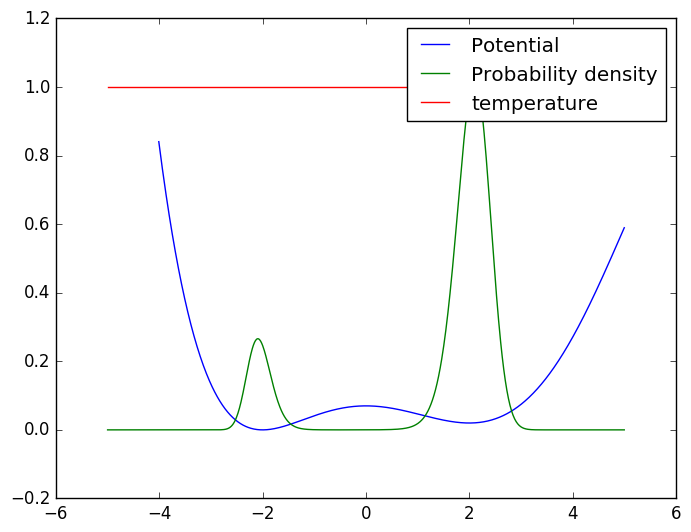

maximum((dpotential * dt) / dx ^ 2) = 1.034711080411645


1.034711080411645

In [4]:
# Initialize the system and simulate forward until we are in the Kramers regime, we can then use this as a starting for
# measuring the Kramers rate.
LL = 1.0  # Length scale of the system.
T0 = 1.0  # Temperature unit. 
scaling = 2.0  # The distance of the wells from each other.
extend = 5.0  # The amount of the xAxis that we want to use.

nPoints = 1000 # The number of points on the xAxis.
nSteps = 550000  # Number of steps to take.
dt = 3e-6  # Time step.

xAxis = linspace(-extend*LL, extend*LL, nPoints)
dx = (xAxis[end] - xAxis[1])/nPoints # Grid spacing

wellPositions = [-scaling, 0.0, scaling]
# Make the potential from a polynomial. 
coeff = hermite_coeff(wellPositions, [0.0, 7.0, 2.0], [0.0, 0.0, 0.0])
function V(x, coeff)
    acc = 0
    for ii = 1:length(coeff)
        acc += coeff[ii]*x^(ii-1)
    end
    acc
end
V(x) = V(x, coeff)
dV(x) = ForwardDiff.derivative(V, x)

potential = Float64[V(x) for x in xAxis]
dpotential = [dV(xAxis[1] - dx) ; Float64[dV(x) for x in xAxis] ; dV(xAxis[end] + dx)]

# Make a vector containg the temperature.
tempFun(x) = T0
temperature = Float64[tempFun(x) for x in xAxis]

# Make a vector containing the probability density, we want the probability density to be completely located in the upper
# well to being with.
sigma  = 0.1
P0 = Float64[(1/(sigma*sqrt(2pi)))*exp(-((x - scaling)^2)/(2sigma^2))
              for x in xAxis]
P0 /= discrete_quad(P0, xAxis[1], xAxis[end])
density = P0

# Make the system.
system = System()
system.density = density
system.potential = potential
system.dpotential = dpotential
system.temperature = temperature
system.xAxis = xAxis

# Simulate the system in the uncoupled sense.
@time begin
    for i in 2:nSteps
        system.density = stepP(system, dt; bndType = :absorbing, normalization = true)
    end
end

initDensity = system.density
plot(system.xAxis[100:end], 0.01system.potential[100:end],
                system.xAxis, system.density, system.xAxis, system.temperature)
legend(["Potential", "Probability density", "temperature"])

@show maximum(dpotential*dt/dx^2)

# Calculating the Kramer's rate.
Once we have a system in the Kramer's regime, we can calculate the Kramer's rate by calculating the probability that the particle is in the right well with time. We will call this variable `pRight`, in Kramer's regime $P_{Right}(t) = A \exp(-k t)$ for some constant $A$. Therefore if we calculate the slope of `pRight` on a log plot, then we will recover $k$ which is the Kramer's rate.  

In [5]:
system = System()
system.density = initDensity
system.potential = potential
system.dpotential = dpotential
system.temperature = temperature
system.xAxis = xAxis

# Make the important varibles available on all workers.
@constant initDensity initDensity
@constant temperature temperature
@constant xAxis xAxis
@constant system system
@constant wellPositions [-2.0, 0.0, 2.0]
@constant coeff coeff

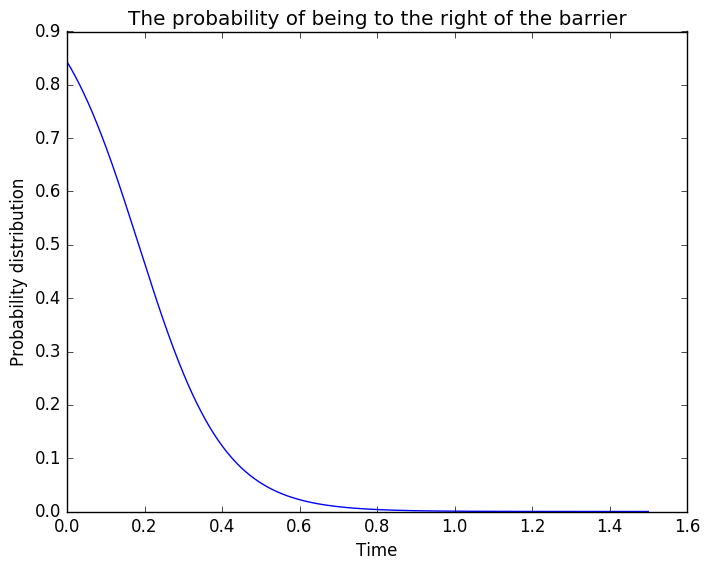

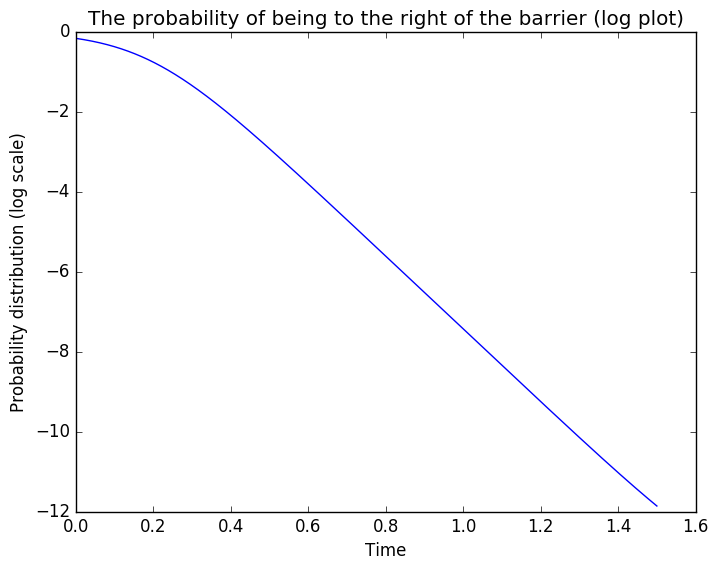

103.153962 seconds (94.50 M allocations: 220.112 GB, 27.51% gc time)


PyObject <matplotlib.text.Text object at 0x31ceab550>

In [6]:
dt = 3e-6
nSteps = 500000
hIndex = round(Int, nPoints/2)
pRight = Array(Float64, nSteps)
pRight[1] = discrete_quad(system.density[hIndex:end],
                            system.xAxis[hIndex], system.xAxis[end])
@time begin
    for i in 2:nSteps
        system.density = stepP(system, dt; bndType = :absorbing, normalization = true)
        pRight[i] = discrete_quad(system.density[hIndex:end],
                            system.xAxis[hIndex], system.xAxis[end])
    end
end

plot((1:nSteps)*dt, pRight)
title("The probability of being to the right of the barrier")
xlabel("Time")
ylabel("Probability distribution")

figure()
plot((1:nSteps)*dt, log(pRight))
title("The probability of being to the right of the barrier (log plot)")
xlabel("Time")
ylabel("Probability distribution (log scale)")

As we can see, if one calculates the slope of the log plot, then one will get the Kramer's rate. This process has been automated in the function `measure_kramers`, which will calculate the Kramer's rate of a system.

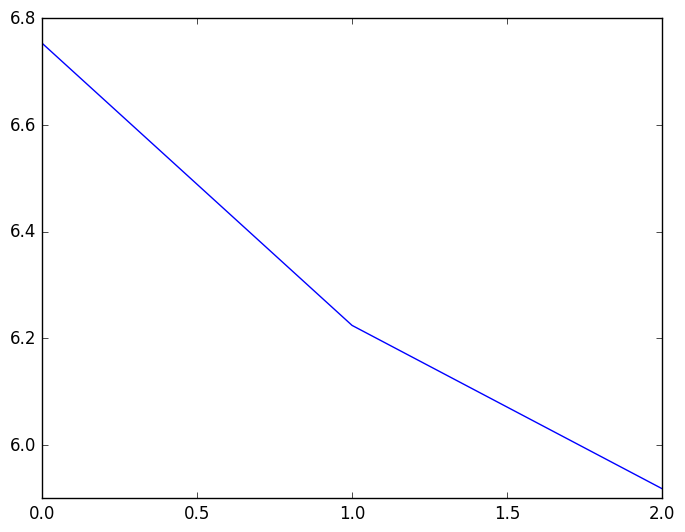

241.195762 seconds (168.83 k allocations: 7.948 MB, 0.02% gc time)


1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x324697b90>

In [7]:
nn = 3  # The number of different barrier heights to use.
barrier = linspace(7.0, 11, nn)  # The different barrier heights to try out.
# Reinitialize the system.
system = System()
system.density = initDensity
system.potential = potential
system.dpotential = dpotential
system.temperature = temperature
system.xAxis = xAxis
@everywhere begin
    nn = 3
    dt = 3e-7
    nSteps = 1000000
end

@time kkNumeric = pmap(x -> measure_kramers(wellPositions,
                        hermite_coeff(wellPositions, [0.0, x, 2.0], [0.0, 0.0, 0.0]),
                        initDensity, temperature, xAxis,
                        dt, nSteps), barrier)
plot(kkNumeric)

# Generalizing to the coupled system
We would like to calculate the Kramer's rate in the coupled system, we will use the excact same procedure, below we show a plot of `pRight` to show that the dynamics can be different in the coupled system.

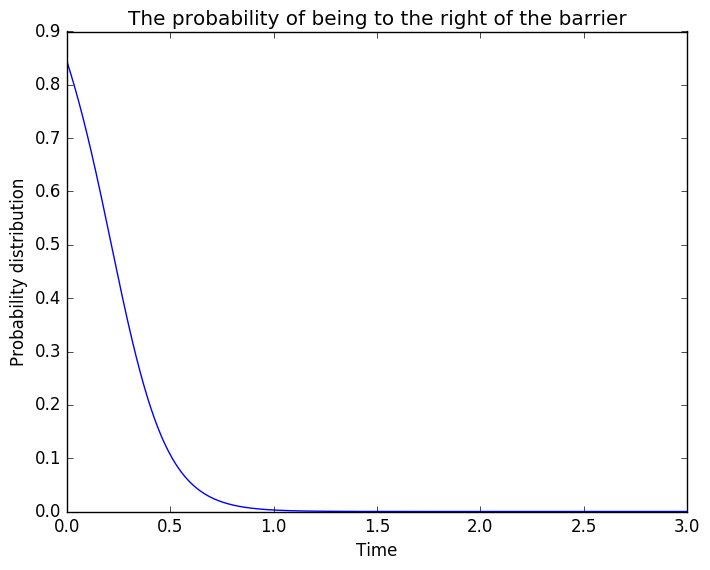

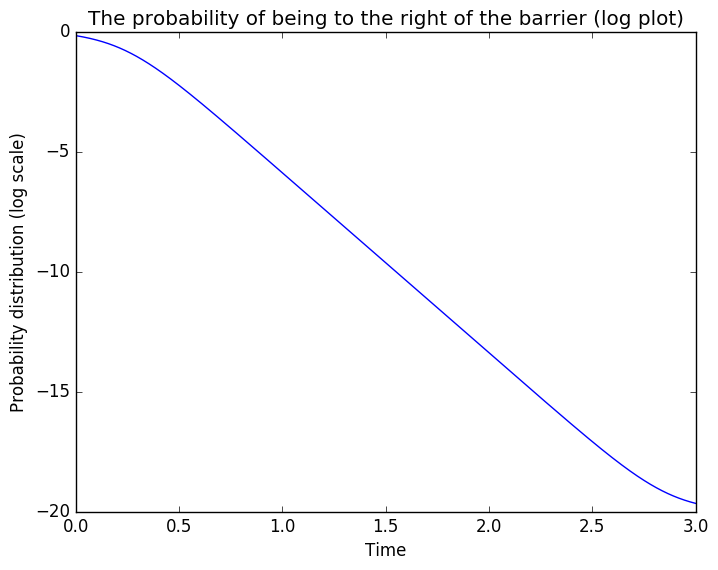

455.214173 seconds (419.41 M allocations: 888.975 GB, 24.93% gc time)


PyObject <matplotlib.text.Text object at 0x32811a690>

In [8]:
alpha = 1e-4
beta = 1e-3
dt = 3e-6
nSteps = 1000000
hIndex = round(Int, nPoints/2)
pRight = Array(Float64, nSteps)
pRight[1] = discrete_quad(system.density[hIndex:end],
                            system.xAxis[hIndex], system.xAxis[end])
@time begin
    for i in 2:nSteps
        system.density = stepP(system, dt; bndType = :absorbing, normalization = true)
        system.temperature = stepT(system, alpha, beta, dt; bndType = :neumann)
        pRight[i] = discrete_quad(system.density[hIndex:end],
                            system.xAxis[hIndex], system.xAxis[end])
    end
end

plot((1:nSteps)*dt, pRight)
title("The probability of being to the right of the barrier")
xlabel("Time")
ylabel("Probability distribution")

figure()
plot((1:nSteps)*dt, log(pRight))
title("The probability of being to the right of the barrier (log plot)")
xlabel("Time")
ylabel("Probability distribution (log scale)")

We have overloaded the function `measure_kramers` so that it can be used to measure the Kramer's rate for the coupled system, simply by passing the varibles `alpha` and `beta` to the function, the function will run the coupled system. Because the temperature is now a function of space an time, we have to impose boundary conditions on it, these can either be Neumann, where the derivative is zero at the boundaries, or Dirichlet where the temperature is held fixed at the boundaries.

643.951544 seconds (88.22 k allocations: 5.261 MB)


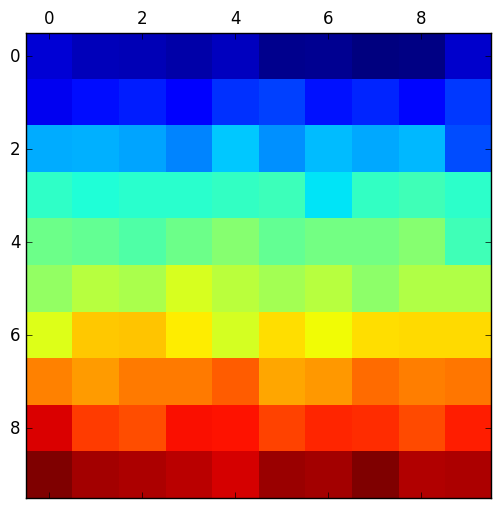

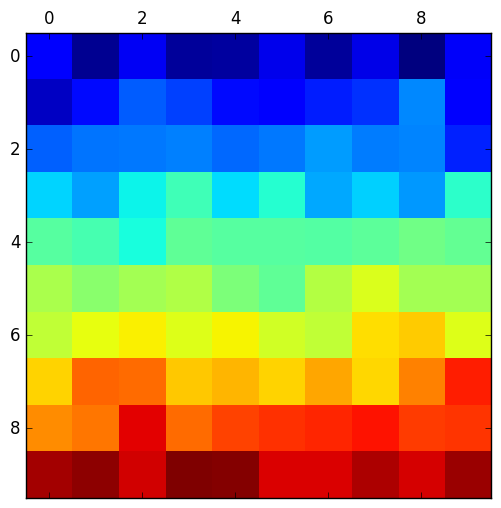

656.989262 seconds (89.55 k allocations: 5.330 MB)


PyObject <matplotlib.image.AxesImage object at 0x32e2568d0>

In [24]:
@everywhere begin
    T0 = 1.0
    nn = 10
    nSteps = 50000
    alphaBeta = [(alpha, beta) for alpha in linspace(1e-4, 3e-4, nn), beta in linspace(1e-4, 1e-1, nn)]
end

@time kkNeumann = pmap(x -> measure_kramers(wellPositions, system, x..., 1e-7, nSteps; tempBndType = :neumann), alphaBeta[:])
kkNeumann = convert(Array{Float64, 1}, kkNeumann)
@time kkDirichlet = pmap(x -> measure_kramers(wellPositions, system, x..., 1e-7, nSteps; tempBndType = :dirichlet), alphaBeta[:])
kkDirichlet = convert(Array{Float64, 1}, kkDirichlet)

matshow(reshape(kkNeumann, nn, nn))
figure()
matshow(reshape(kkDirichlet, nn, nn))

# Reverse Landauer blowtorch
We have seen that if one enforces a temperature gradient on a bistable potential, then the particles feel a psuedo-force due to the temperature gradient. Here we will show that under the right conditions, the opposite may occur, namely that if we start with all of the particles in the upper well and run the system forward for some time, then we will find that the upper well will become colder than the lower one.

In [25]:
nSteps = 200000
dt = 1e-6
alpha = 5e-3
beta = 1e-6
# Reinitialize the system.
system = System()
system.density = initDensity
system.potential = potential
system.dpotential = dpotential
system.temperature = temperature
system.xAxis = xAxis
system.energy = energyFun(system, alpha)

energyVec = Array(Float64, nSteps)
energyVec[1] = system.energy
for i = 1:nSteps
#     system.energy, system.temperature = stepT(system, alpha, beta, dt; bndType=:dirchlet)
    system.temperature = stepT(system, alpha, beta, dt; bndType=:neumann)
    system.density = stepP(system, dt)
    energyVec[i] = system.energy
end

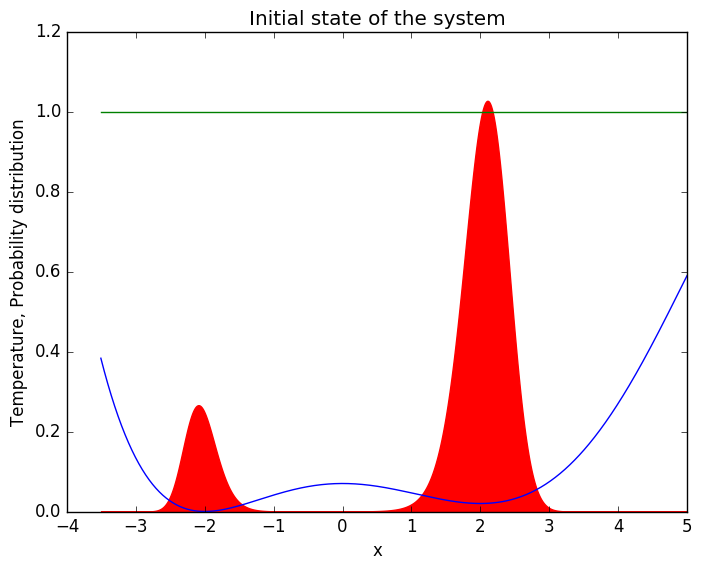

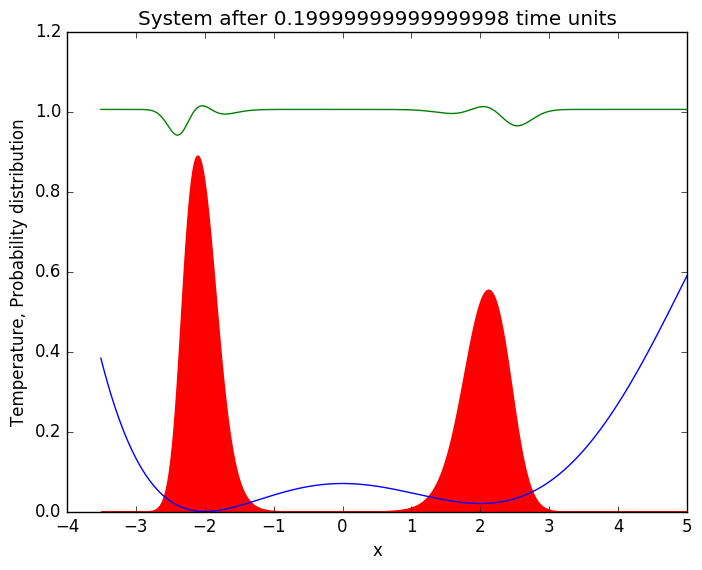

PyObject <matplotlib.text.Text object at 0x32d255e50>

In [26]:
startIndex = 150  # The left side of the potential is very high, so we would like to cut it out.

# Plot the initial state of the system and the state of the system after the simulation.
fill_between(xAxis[startIndex:end], initDensity[startIndex:end], color = :red)
plot(xAxis[startIndex:end], 0.01potential[startIndex:end])
plot(xAxis[startIndex:end], temperature[startIndex:end])
title("Initial state of the system")
xlabel("x")
ylabel("Temperature, Probability distribution")
# legend(["Potential", "Temperature", "Probability distribution"])

figure()
fill_between(xAxis[startIndex:end], system.density[startIndex:end], color = :red)
plot(xAxis[startIndex:end], 0.01system.potential[startIndex:end])
plot(xAxis[startIndex:end], system.temperature[startIndex:end])
title("System after $(dt*nSteps) time units")
xlabel("x")
ylabel("Temperature, Probability distribution")
# legend(["Potential", "Temperature", "Probability distribution"])